# Aplicación de filtro de partículas a seguimiento visual

Actividad realizada por Sergio Hernández García para el curso de Introducción a los Métodos Bayesianos para la Inferencia Estadística 2022.

En este notebook se realiza un ejemplo de aplicación de los contenido vistos sobre filtro de partículas a un caso de seguimiento visual de una persona.

En primer lugar se importan los paquetes necesarios:

In [1]:
import cv2
import os
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

La siguiente función nos permite visualizar las partículas

In [2]:
def print_particles(img, particulas, y_best = None, x_best = None, color=(0, 0, 255)):
    h, w = 80, 40
    if particulas:
        index = np.random.choice(range(len(particulas['estados'])), int(len(particulas['estados'])*0.5), replace=False)
        estados = particulas['estados'][index]
        peso_p = particulas['peso']*7 + 1

        for i in range(estados.shape[0]):
            y = estados[i, 0]
            x = estados[i, 1]
            img_copy = img.copy()
            img = cv2.circle(img, center=(int(x+w/2), int(y+h/2)), radius=int(peso_p[i])*2, color=(0, 0, 255), thickness=-1)

            alpha = 0.7  # Transparency factor.
            # Following line overlays transparent rectangle over the image
            img = cv2.addWeighted(img_copy, alpha, img, 1 - alpha, 0)

    if y_best and x_best:
        img = cv2.rectangle(img, (int(x_best-w/2), int(y_best-h/2)), (int(x_best + w/2), int(y_best + h/2)), color, 2)

    return img

Cargamos la secuencia sobre la que se va a aplicar el algoritmo.

In [3]:
ruta = "PETS09-S2L1/"
ruta_img = [os.path.join(ruta, '{:03d}.jpg'.format(i)) for i in range(1, 61)]

Definimos el número de partículas que se van a muestrear y un diccionario para guardar las coordenas de cada partícula junto con su peso.

In [4]:
n = 1000
particulas = {'estados': np.zeros((n,2)),
              'peso': np.zeros(n)}

y_best, x_best = None, None

## Visualización de dos iteraciones
Con fines demostrativos suponemos que estamos en el instante t=10, por lo que leemos el fotograma número 10.

In [5]:
frame_rgb = mpimg.imread(ruta_img[10])

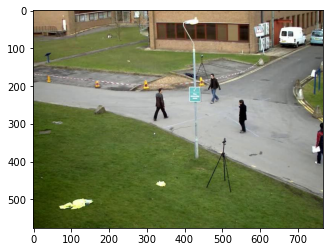

In [6]:
plt.imshow(frame_rgb)
plt.show()

### t = 10
En las primera iteración sabemos que el objeto a seguir está en torno a las coordenadas (320, 220), muestreamos de una distribución normal centrada en (320, 250) para cubrir una sección de la imagen cercana a esas coordenadas.

In [7]:
mu = [220, 320]
sigma = 20
particulas['estados'] = np.random.normal(mu, sigma, size=(n, 2)).astype(int)

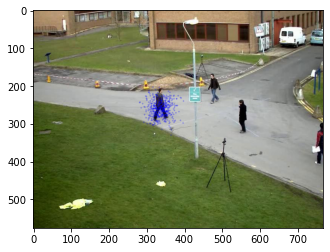

In [8]:
img_particles =  print_particles(frame_rgb, particulas)
plt.imshow(img_particles)
plt.show()

Realizamos una sustracción de fondo para detectar la posición de las distintas personas que aparecen en la imagen.

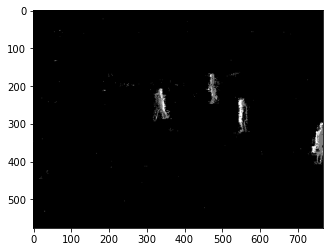

In [9]:
# Sustraccion de fondo
fgbg = cv2.createBackgroundSubtractorMOG2()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# La sustracción de fondo necesita procesar varios frames consecutivos.
for i in range(11):
    frame_rgb = mpimg.imread(ruta_img[i])
    th = fgbg.apply(frame_rgb)
    th = cv2.erode(th, kernel)
th = fgbg.apply(frame_rgb)
plt.imshow(th, cmap='gray')
plt.show()

Calculamos la likelihood de cada partícula. Para esto, realizamos un recuento del número de píxeles pertenecientes al area segmentada en la imagen que se encuentran dentro de un rectángulo de tamaño 40x80 con centro en las coordenadas de cada partícula.

In [10]:
h, w = 80, 40
estados = particulas['estados']

for i in range(estados.shape[0]):
    y = estados[i, 0]
    x = estados[i, 1]
    particulas['peso'][i] = np.sum(th[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)])

# Normalizamos los pesos
total = np.sum(particulas['peso'])
particulas['peso'] = particulas['peso']/total

Remuestreamos de la likelihood para seleccionar una partícula.

In [11]:
# Muestreamos con pesos=particulas['peso']
index = np.random.choice(range(n), p=particulas['peso'])
y_sample = particulas['estados'][index,0]
x_sample  = particulas['estados'][index,1]

print('x=', y_sample, ' y=', x_sample, ' peso=', particulas['peso'][index])

x= 243  y= 330  peso= 0.002818376733295779


Mostramos las partícula remuestreada.

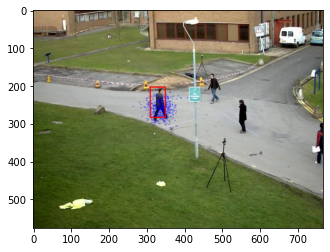

In [12]:
img_particles = print_particles(frame_rgb, particulas, y_sample, x_sample, color=(255, 0, 0))
plt.imshow(img_particles)
plt.show()

### t = 11
En esta iteración ya se dispone de una estimación de la posición del objeto (x_sample, y_sample). En esta ocasión muestrearemos de una normal centrada en (x_sample, y_sample) varianza definida por el usuario.

In [13]:
pesos_acum = particulas['peso']

# Calcular CDF
for i in range(1, pesos_acum.shape[0]):
    pesos_acum[i] = pesos_acum[i-1] + pesos_acum[i]

random.seed(None)

# Remuestrear de la distribución
for i in range(pesos_acum.shape[0]):
    rand = random.random()
    j = 0

    # Seleccionar primer ejemplo con probabilidad acumulada mayor que rand
    while j < pesos_acum.shape[0] and pesos_acum[j] < rand:
        j = j+1

    # Muestrear de una normal con media en el estado j.
    if j < pesos_acum.shape[0]:
        mu, sigma = 0, 20  # mean and standard deviation

        particulas['estados'][i,0] = particulas['estados'][j,0] + int(np.random.normal(mu, sigma))
        particulas['estados'][i,1] = particulas['estados'][j,1] + int(np.random.normal(mu, sigma))

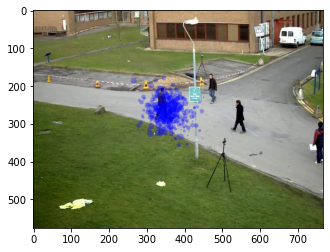

In [14]:
frame_rgb = mpimg.imread(ruta_img[11])

img_particles = print_particles(frame_rgb, particulas)
plt.imshow(img_particles)
plt.show()

Realizamos una sustracción de fondo para detectar la posición de las distintas personas que aparecen en la imagen.


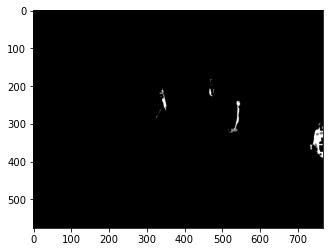

In [15]:
th = fgbg.apply(frame_rgb)
th = cv2.erode(th, kernel)
plt.imshow(th, cmap='gray')
plt.show()

Calculamos la likelihood de cada partícula. Para esto, realizamos un recuento del número de píxeles pertenecientes al area segmentada en la imagen que se encuentran dentro de un rectángulo de tamaño 40x80 con centro en las coordenadas de cada partícula.

In [16]:
h, w = 80, 40
estados = particulas['estados']

for i in range(estados.shape[0]):
    y = estados[i, 0]
    x = estados[i, 1]
    particulas['peso'][i] = np.sum(th[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)])

# Normalizamos los pesos
total = np.sum(particulas['peso'])
particulas['peso'] = particulas['peso']/total

Remuestreamos de la likelihood para seleccionar una partícula.


In [17]:
# Muestreamos con pesos=particulas['peso']
index = np.random.choice(range(n), p=particulas['peso'])
y_sample = particulas['estados'][index,0]
x_sample  = particulas['estados'][index,1]

print('x=', y_sample, ' y=', x_sample, ' peso=', particulas['peso'][index])

x= 249  y= 334  peso= 0.002940228176453719


Mostramos la partícula remuestreada.

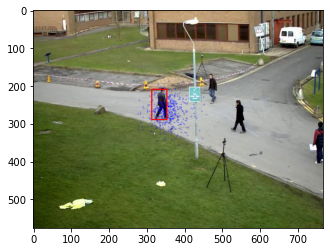

In [18]:
img_particles = print_particles(frame_rgb, particulas, y_sample, x_sample, color=(255, 0, 0))
plt.imshow(img_particles)
plt.show()

## Ejemplo  de seguimiento visual en video

Encapsulamos en funciones el código mostrado anteriormente.
El video seleccionado (PETS09-S2L1) es una tarea clásica de seguimiento de múltiples objetos y presenta grandes dificultades para mántener la identidad de cada sujeto cuando se cruzan. Es por esto que el filtro de partículas necesitaría alguna información a priori relacionada con la dirección del movimiento del sujeto para poder mantener la identidad.
Aún así, el video sirve de ejemplo de un caso práctico de aplicación de filtro de partículas.

In [19]:
def select_particles(particulas):

    y_best, x_best = select_best_particle(particulas)

    pesos_acum = particulas['peso']

    for i in range(1, pesos_acum.shape[0]):
        pesos_acum[i] = pesos_acum[i-1] + pesos_acum[i]

    random.seed(None)

    for i in range(pesos_acum.shape[0]):
        rand = random.random()
        j = 0

        while j < pesos_acum.shape[0] and pesos_acum[j] < rand:
            j = j+1

        if j < pesos_acum.shape[0]:
            mu, sigma = 0, 20  # mean and standard deviation

            particulas['estados'][i,0] = particulas['estados'][j,0] + int(np.random.normal(mu, sigma))
            particulas['estados'][i,1] = particulas['estados'][j,1] + int(np.random.normal(mu, sigma))

    return y_best, x_best

def calcular_pesos(img, particulas):
    h, w = 80, 40
    estados = particulas['estados']

    for i in range(estados.shape[0]):
        y = estados[i, 0]
        x = estados[i, 1]
        particulas['peso'][i] = np.sum(img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)])
    total = np.sum(particulas['peso'])

    if total != 0:
        particulas['peso'] = particulas['peso']/total

def select_best_particle(particulas):
    if np.sum(particulas['peso']) == 1:
        index = np.random.choice(range(n), p=particulas['peso'])
    # index = np.argmax(particulas['peso'])
    # if particulas['peso'][index] > 0:
        return particulas['estados'][index,0], particulas['estados'][index,1]
    else:
        return None, None

Definimos el número de partículas que se van a muestrear y reiniciamos el diccionario que guarda las coordenas de cada partícula junto con su peso.

In [20]:
n = 1000
particulas = {'estados': np.zeros((n,2)),
              'peso': np.zeros(n)}

y_best, x_best = None, None

Ejecutamos el algoritmo y generamos un video con el resultado.
NOTA: aunque ocurra un error al crear el video, los fotogramas que lo forman se guardarán en la carpeta resultados

In [ ]:
video_frames = []
for img in ruta_img:
    frame_rgb = cv2.imread(img, cv2.IMREAD_COLOR)

    if not y_best and not x_best:
        mu = [220, 320]
        sigma = 20
        particulas['estados'] = np.random.normal(mu, sigma, size=(n, 2)).astype(int)
        particulas['estados'] = particulas['estados'].astype(int)

    # Sustraccion de fondo
    th = fgbg.apply(frame_rgb)
    th = cv2.erode(th, kernel)
    #calculo pesos
    calcular_pesos(th, particulas)

    y_best, x_best = select_particles(particulas)

    img_particles = print_particles(frame_rgb, particulas, y_best, x_best, color=(255, 0, 0))
    video_frames.append(img_particles)

try:
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    writer = cv2.VideoWriter('filtro_particulas.mp4', fourcc, 25, (frame_rgb.shape[1], frame_rgb.shape[0]))
    for frame in video_frames:
        writer.write(frame)

    writer.release()
except:
    print('error al crear el video')
    
finally:
    # Guardar los fotogramas en la carpeta resultados
    if not os.path.isdir('resultado'):
        os.mkdir('resultado')
    for i in range(len(video_frames)):
        plt.imsave('resultado/{:03d}.jpg'.format(i), cv2.cvtColor(video_frames[i], cv2.COLOR_BGR2RGB))

In [ ]:
from ipywidgets import Video, Image
from IPython.display import display
import numpy as np
import cv2
import base64

Mostramos el video.
NOTA: en caso de que no se posible reproducirlo, se puede acceder a él en el menú lateral para verlo.

In [ ]:
video = Video.from_file('filtro_particulas.mp4')
video